## ImageNet 模型

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, datasets

In [2]:
url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
model = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape=(224, 224, 3))
])

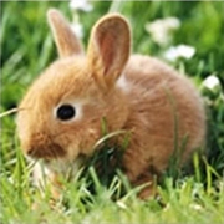

In [3]:
tutu = tf.keras.utils.get_file('tutu.png','https://geektutu.com/img/icon.png')
tutu = Image.open(tutu).resize((224, 224))
tutu

In [4]:
result = model.predict(np.array(tutu).reshape(1, 224, 224, 3)/255.0)
ans = np.argmax(result[0], axis=-1)
print('result.shape:', result.shape, 'ans:', ans)

result.shape: (1, 1001) ans: 332


In [5]:
labels_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', labels_url)
imagenet_labels = np.array(open(labels_path).read().splitlines())
print(imagenet_labels[ans])

hare


## 迁移学习

### resize 数据集

In [6]:
def resize(d, size=(224, 224)):
    return np.array([np.array(Image.fromarray(v).resize(size, Image.ANTIALIAS))
                     for i, v in enumerate(d)])

(train_x, train_y), (test_x, test_y) = datasets.cifar10.load_data()
train_x, test_x = resize(train_x[:30000])/255.0, resize(test_x)/255.0

In [7]:
train_y = train_y[:30000]

### 下载特征提取层

In [8]:
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
# 这一层的训练值保持不变
feature_extractor_layer.trainable = False

### 添加分类层

In [9]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


### 训练并评估模型

In [10]:
history = model.fit(train_x, train_y, epochs=1)
loss, acc = model.evaluate(test_x, test_y)
print(acc)

W0720 22:12:00.175307 140735530943360 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 30000 samples
10000/10000 [==============================] - 256s 26ms/sample - loss: 0.7636 - acc: 0.7657
0.7657
